In [305]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, RocCurveDisplay)
from imblearn.metrics import specificity_score

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re



from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier



import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [306]:
df_selftext = pd.read_csv('../data/cleaned_selftext.csv')
df_notext = pd.read_csv('../data/cleaned_notext.csv')
df_selftext.head(2)

,subreddit,text
0,0,using electric water boiler to mine bitcoin th...
1,0,btc to usdt hello i am looking to swap a good ...


In [257]:
print(df_selftext.subreddit.value_counts())
df_notext.subreddit.value_counts()

0    3507
1     789
Name: subreddit, dtype: int64


0    8584
1    2077
Name: subreddit, dtype: int64

# Adding stop words to not make it too easy

In [258]:
stop = list(stopwords.words('english'))
stop.extend('btc eth bitcoin ethereum lightning vitalik metamask nft nfts'.split())


# TTS

In [259]:
X = df_selftext.text
y = df_selftext.subreddit

In [260]:
# baseline
y.value_counts(normalize=True)

0    0.816341
1    0.183659
Name: subreddit, dtype: float64

In [261]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

# Model 1: NB

In [262]:
# Pipeline accepts multiple transformers, but only one vectorizer. See cgpt results:

'''The error message is caused by the fact that you are trying to fit two different vectorizers (TfidfVectorizer and CountVectorizer) 
in the same pipeline, but only providing one input (X_train) to the pipeline. This is causing the pipeline to raise an error as it doesn't 
know which vectorizer to apply to the input. 

You can fix this by either removing one of the vectorizers or providing separate inputs to the pipeline for each vectorizer.'''


nb_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [263]:
nb_pipe_params = {
    'tvec__max_features': range(600,800,5),
    'tvec__stop_words': [stop],
    'tvec__ngram_range': [(1,1), (1,2), (1,3),(2,3),(3,3)],
    'nb__alpha': [.01, .05, .1, .25, .5, .1]
}

In [264]:
nb_rs = RandomizedSearchCV(nb_pipe, 
                  nb_pipe_params, 
                    cv = 5) 

In [265]:
nb_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                             ('nb', MultinomialNB())]),
                   param_distributions={'nb__alpha': [0.01, 0.05, 0.1, 0.25,
                                                      0.5, 0.1],
                                        'tvec__max_features': range(600, 800, 5),
                                        'tvec__ngram_range': [(1, 1), (1, 2),
                                                              (1, 3), (2, 3),
                                                              (3, 3)],
                                        'tvec__stop_words': [['i', 'me', 'my',
                                                              'myself', 'we',
                                                              'our', 'ours',
                                                              'ourselves',
                                                              'you', 

# Model 2: LR

In [266]:
logr_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logr', LogisticRegression())
])

In [267]:
logr_pipe_params = {
    'tvec__max_features': range(600,800,5),
    'tvec__stop_words': [stop],
    'tvec__ngram_range': [(1,1), (1,2), (1,3),(2,3),(3,3)],
    'logr__C': [.01, .1 ,.5 , 1.0, 2, 5, 10]
}

In [268]:
logr_rs = RandomizedSearchCV(logr_pipe, 
                  logr_pipe_params, 
                    cv = 5) 

In [269]:
logr_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                             ('logr', LogisticRegression())]),
                   param_distributions={'logr__C': [0.01, 0.1, 0.5, 1.0, 2, 5,
                                                    10],
                                        'tvec__max_features': range(600, 800, 5),
                                        'tvec__ngram_range': [(1, 1), (1, 2),
                                                              (1, 3), (2, 3),
                                                              (3, 3)],
                                        'tvec__stop_words': [['i', 'me', 'my',
                                                              'myself', 'we',
                                                              'our', 'ours',
                                                              'ourselves',
                                                              'you',

In [270]:
print(logr_rs.score(X_train, y_train))
logr_rs.score(X_test, y_test)

0.8919925512104283


0.88268156424581

# Model 3: knn

In [271]:
# mean = False here for memory error. see individual model for model with mean = True

knn = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('ss', StandardScaler(with_mean=False)),
    ('knn', KNeighborsClassifier())
])

In [272]:
knn_params = {
    'tvec__max_features': range(100,1000,100),
    'tvec__stop_words': [stop],
    'tvec__ngram_range': [(1,1), (1,2), (1,3),(2,3),(3,3)],
    'knn__n_neighbors': range(1,20)
    
}

In [273]:
knn_rs = RandomizedSearchCV(knn, knn_params, cv = 4)

knn_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=4,
                   estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                             ('ss',
                                              StandardScaler(with_mean=False)),
                                             ('knn', KNeighborsClassifier())]),
                   param_distributions={'knn__n_neighbors': range(1, 20),
                                        'tvec__max_features': range(100, 1000, 100),
                                        'tvec__ngram_range': [(1, 1), (1, 2),
                                                              (1, 3), (2, 3),
                                                              (3, 3)],
                                        'tvec__stop_words': [['i', 'me', 'my',
                                                              'myself', 'we',
                                                              'our', 'ours',
                                                              'oursel

In [274]:
print(knn_rs.score(X_train, y_train))
knn_rs.score(X_test, y_test)

0.8519553072625698


0.8305400372439479

# Model 4: RF Boosted

In [328]:
ada = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('ada', AdaBoostClassifier(base_estimator = RandomForestClassifier()))
])

In [329]:
ada_params = {
    'tvec__max_features': range(650,750,5),
    'tvec__stop_words': [stop],
    'tvec__ngram_range': [(1,1), (1,2), (1,3),(2,3),(3,3)],
    'ada__n_estimators': range(100,200, 5)
}

In [331]:
ada_rf_rs = RandomizedSearchCV(ada, ada_params, cv = 4)

ada_rf_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=4,
                   estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                             ('ada',
                                              AdaBoostClassifier(base_estimator=RandomForestClassifier()))]),
                   param_distributions={'ada__n_estimators': range(100, 200, 5),
                                        'tvec__max_features': range(650, 750, 5),
                                        'tvec__ngram_range': [(1, 1), (1, 2),
                                                              (1, 3), (2, 3),
                                                              (3, 3)],
                                        'tvec__stop_words': [['i', 'me', 'my',
                                                              'myself', 'we',
                                                              'our', 'ours',
                                                              'ourselves',
                                       

In [332]:
print(ada_rf_rs.score(X_train, y_train))
ada_rf_rs.score(X_test, y_test)

0.999689633767846


0.8296089385474861

# Model 5: Gradient boosting DT

In [279]:
gb_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('gb', GradientBoostingClassifier())
])

In [280]:
gb_pipe_params = {
    'tvec__max_features': range(600,800,5),
    'tvec__stop_words': [stop],
    'tvec__ngram_range': [(1,1), (1,2), (1,3),(2,3),(3,3)],
    'gb__n_estimators': range(50,200,50),
    'gb__max_features': range(50, 80)
}

In [281]:
gb_rs = RandomizedSearchCV(gb_pipe, 
                  gb_pipe_params, 
                    cv = 5) 

In [282]:
gb_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                             ('gb',
                                              GradientBoostingClassifier())]),
                   param_distributions={'gb__max_features': range(50, 80),
                                        'gb__n_estimators': range(50, 200, 50),
                                        'tvec__max_features': range(600, 800, 5),
                                        'tvec__ngram_range': [(1, 1), (1, 2),
                                                              (1, 3), (2, 3),
                                                              (3, 3)],
                                        'tvec__stop_words': [['i', 'me', 'my',
                                                              'myself', 'we',
                                                              'our', 'ours',
                                                              'ourselves

In [283]:
print(gb_rs.score(X_train, y_train))
gb_rs.score(X_test, y_test)

0.9006828057107387


0.8677839851024208

# Model 6: Stack

In [ ]:
stack_estimators = [
    ('nb_pipe', nb_rs.best_estimator_),
    ('ada_pipe', ada_rf_rs.best_estimator_),
    ('gb_pipe', gb_rs.best_estimator_),
    ('logr_pipe', logr_rs.best_estimator_)   
]

stack = StackingClassifier(estimators=stack_estimators, final_estimator=LogisticRegression())

cross_val_score(stack, X_train, y_train).mean()


In [ ]:
stack.fit(X_train, y_train)

In [ ]:
print(stack.score(X_train, y_train))
stack.score(X_test, y_test)

# Let's get some coeffs

In [316]:
logr_rs.score(X_train, y_train)

0.8919925512104283

In [324]:
logr_rs['logr_rs'].best_estimator_.regressor_.coef_

TypeError: 'RandomizedSearchCV' object is not subscriptable

In [ ]:
print(ada_rf_rs.best_estimator_.named_steps[base_estimator].feature_importances_)

# Make list of models

In [287]:
models = [nb_rs, logr_rs, knn_rs, ada_rf_rs, gb_rs, stack]
modelsstr =  ['nb_rs', 'logr_rs', 'knn_rs', 'ada_rf_rs', 'gb_rs', 'stack']

# Generate predictions for models

In [288]:
def preds_gen(estimator):
    return estimator.predict(X_test)

preds_array = []

for i in models:
    preds_array.append(preds_gen(i))

In [289]:
def confusion_matrices(model, preds):
    
    cm = confusion_matrix(y_test, preds)

    display = ConfusionMatrixDisplay(confusion_matrix = cm,
                                 display_labels = model.classes_)
    display.plot();



# Generate confusion matrices

In [ ]:
for i in preds_array:
    tn, fp, fn, tp = confusion_matrix(y_test, i).ravel()
    print(tn, fp, fn, tp)

nb_rs
[[862  15]
 [137  60]]
logr_rs
[[858  19]
 [107  90]]
knn_rs
[[872   5]
 [177  20]]
ada_rf_rs
[[872   5]
 [190   7]]
gb_rs
[[857  20]
 [122  75]]
stack
[[848  29]
 [ 96 101]]


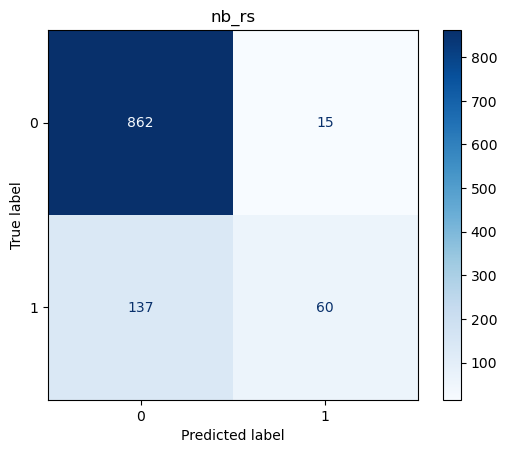

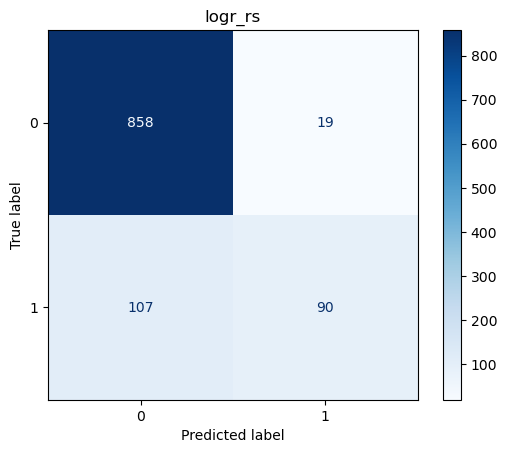

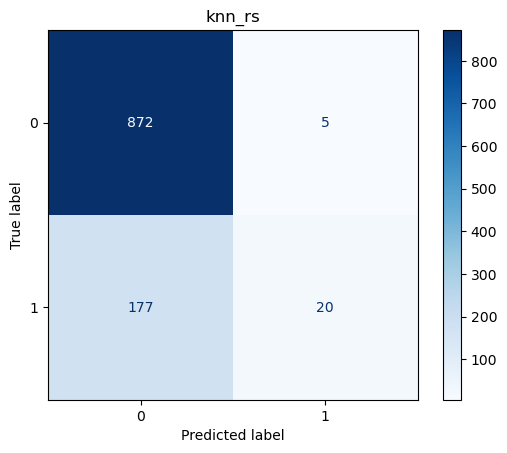

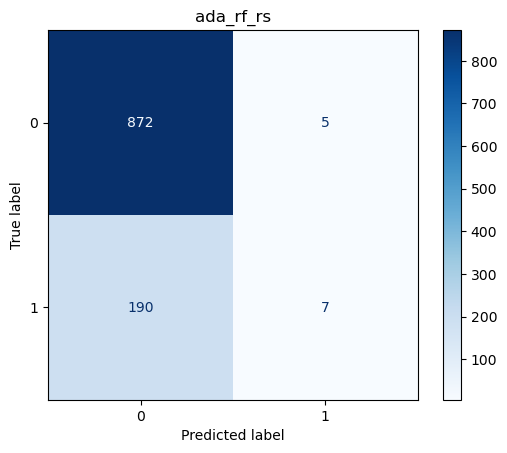

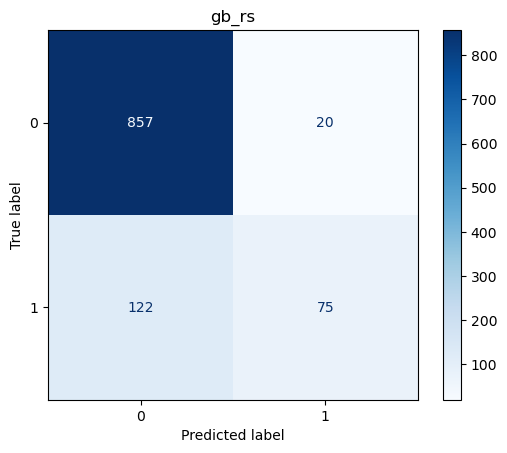

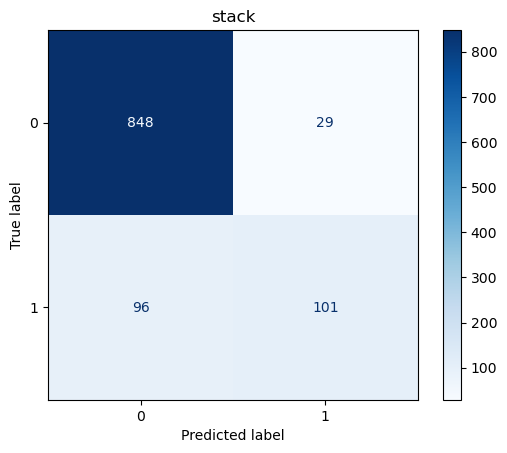

In [290]:
count = 0
for i,z in zip(models, preds_array):
    
    title = modelsstr[count]
    
    cm = confusion_matrix(y_test, z)
    
    disp = ConfusionMatrixDisplay.from_estimator(
        i,
        X_test,
        y_test,
        display_labels=i.classes_,
        cmap=plt.cm.Blues,
    )
    disp.ax_.set_title(title)

    print(title)
    count+=1
    print(disp.confusion_matrix)

# Plot some ROCs

In [291]:
# notes
def ROC(model, name):

    ax = plt.gca()

    # use RocCurveDisplay for both estimators
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax, name=name)

    # add 'worst case scenario' line
    #plt.plot([0,1], [0,1], label='null hypothesis/mean', linestyle='--', color='gray')

    # necessary to label the baseline
    plt.legend();

None
None
None
None
None
None


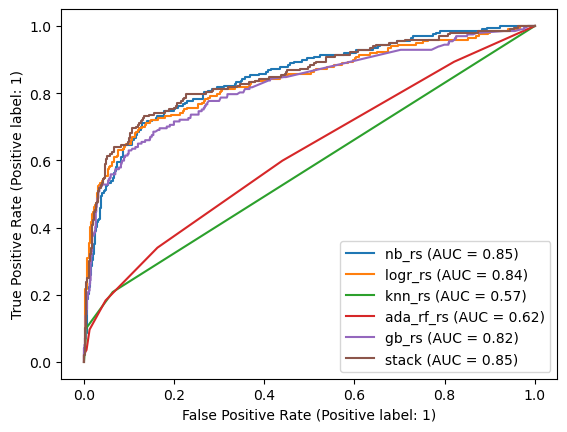

In [292]:
for i in zip(models, modelsstr):
    print(ROC(*i))

# Preds analysis

In [293]:
def pred_dfs(model):

    pred_df = pd.DataFrame(model.predict_proba(X_test),columns=['bitcoin', 'ethereum'])

    pred_df['true_values'] = y_test.values

    return pred_df

In [294]:
nb_preds, logr_preds, knn_preds, ada_preds, gb_preds, stack_preds = [pred_dfs(i) for i in models]

pred_arrays = [nb_preds, logr_preds, knn_preds, ada_preds, gb_preds, stack_preds]

In [295]:
#notes
def class_from_prob(probabilities, threshold):

    return [0 if prob < threshold else 1 for prob in probabilities]


In [296]:
def gen_tables(models, modelsstr):
    counter = 0
    for i in pred_arrays:
        
        threshold_list = [round(i*.01,2) for i in range(0,101,)]
        speclist = []
        senslist = []
        f1list = []

        for threshold in threshold_list:
            predicted_classes = class_from_prob(i['ethereum'], threshold)
            spec = specificity_score(y_test, predicted_classes)
            sens = recall_score(y_test, predicted_classes, pos_label=1)
            speclist.append(spec)
            senslist.append(sens)
            F1 = f1_score(y_test, predicted_classes)
            f1list.append(F1)
        
        
        %matplotlib inline
        fig = plt.figure(figsize = (10,5));
        ax1 = fig.add_subplot(111);

        ax1.scatter(x = threshold_list, y = speclist, s=10, c='b', marker="s", label='specificity');
        ax1.scatter(x = threshold_list,y = senslist, s=10, c='r', marker="o", label='sensitivity');
        ax1.scatter(x = threshold_list,y = f1list, s=10, c='g', marker="o", label='F1 score');
        plt.legend(loc='upper left')
        plt.xlabel('Threshold');
        plt.ylabel('Score Value');
        plt.title(f'{modelsstr[counter]}')
        counter +=1 
        plt.show();
        plt.tight_layout();

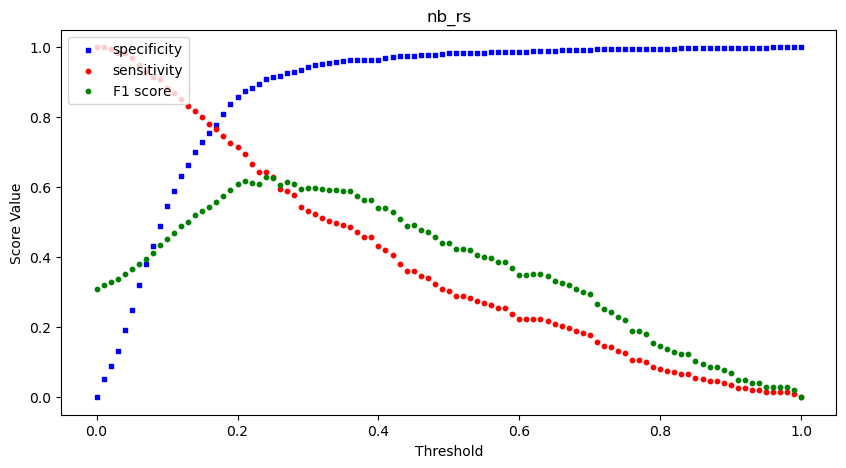

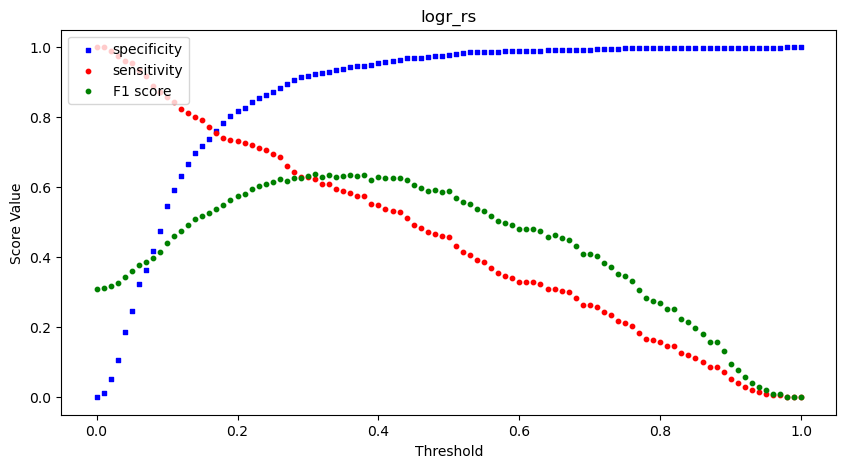

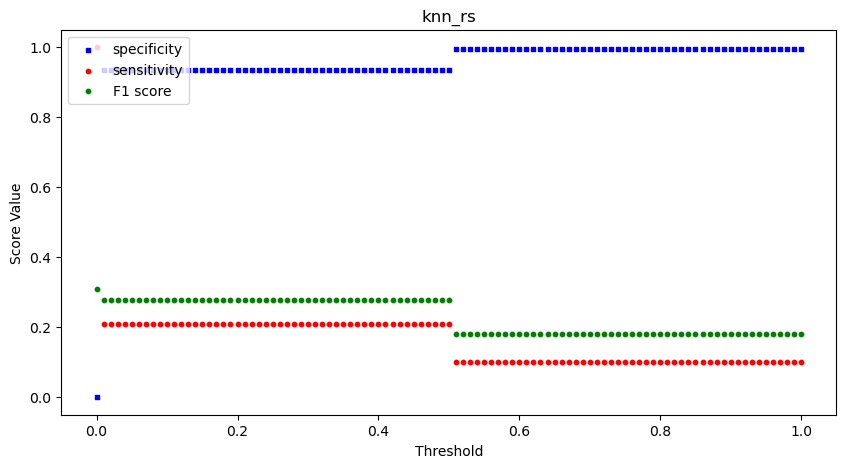

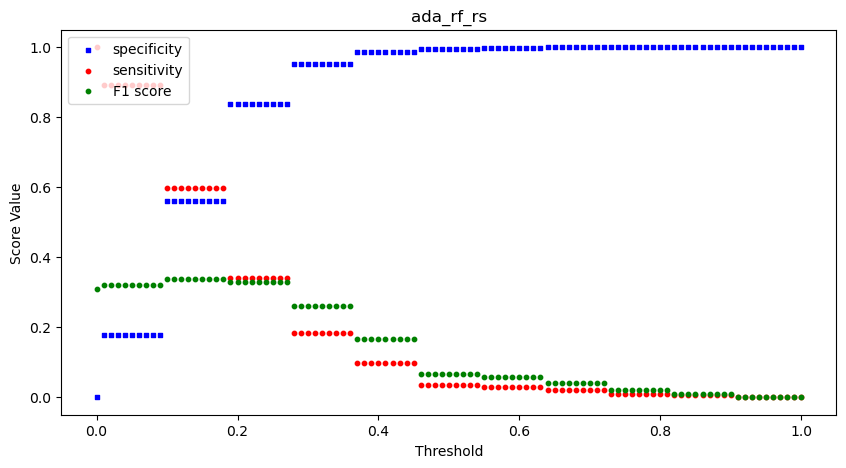

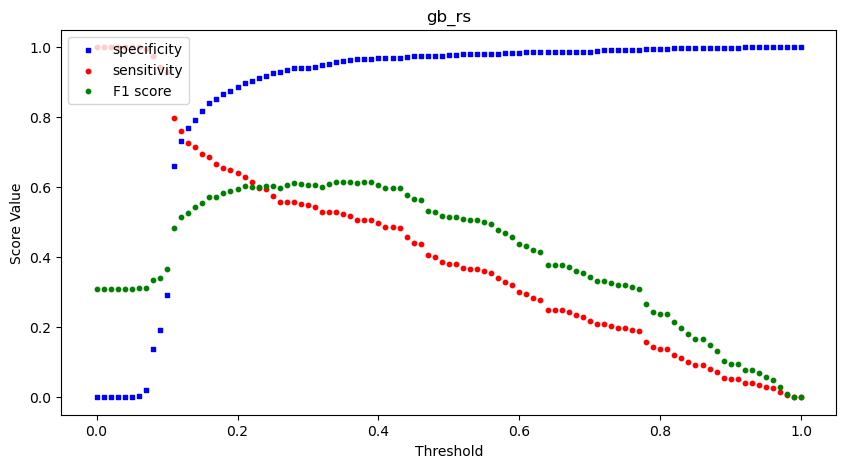

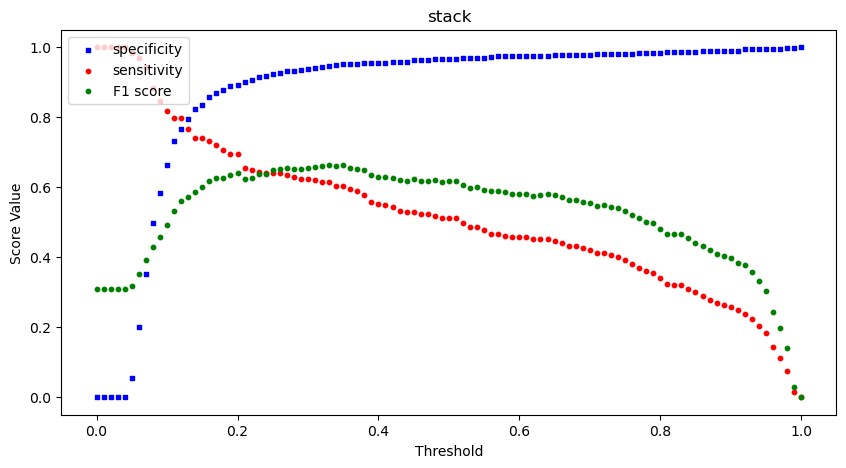

<Figure size 640x480 with 0 Axes>

In [297]:
gen_tables(models, modelsstr)

# More model comparison

# More details (Stack estimator)

In [298]:
pred_df = pd.DataFrame(stack.predict_proba(X_test),columns=['bitcoin', 'ethereum'])

pred_df['true_values'] = y_test.values

pred_df.head()


,bitcoin,ethereum,true_values
0,0.940610,0.059390,0
1,0.899410,0.100590,0
2,0.942837,0.057163,0
3,0.930054,0.069946,0
4,0.933823,0.066177,0


In [299]:
df_selftext = df_selftext.join(pred_df)

In [300]:
df_selftext.sort_values(by = 'bitcoin')[0:100]

,subreddit,text,bitcoin,ethereum,true_values
972,0,look at it from a different perspecti when peo...,0.005554,0.994446,1.0
26,0,btc price during chinese new year doe anybody ...,0.007803,0.992197,0.0
553,0,when bitcoin can wait for this time to arri boom,0.007890,0.992110,1.0
115,0,any clue how to fix error reading from databas...,0.009782,0.990218,1.0
344,0,why can't nation simply adopt bitcoin a the of...,0.010830,0.989170,1.0
...,...,...,...,...,...
279,0,catalyst for bitcoin rally in bitcoin halving ...,0.262615,0.737385,1.0
722,0,how do you think what is the best way to keep ...,0.269483,0.730517,0.0
683,0,is it bitcoins birthday by any chance sorry i'...,0.272142,0.727858,1.0
877,0,can receir adjust fee paid hi doe having rbf s...,0.285014,0.714986,0.0


# False negatives

In [301]:
df_selftext[(df_selftext.true_values == 1) & (df_selftext.bitcoin > .5)].sort_values(by = 'bitcoin', ascending = False)

,subreddit,text,bitcoin,ethereum,true_values
477,0,multi ndor multi sig sparrow wallet one of if ...,0.951396,0.048604,1.0
854,0,can i reuse qr code and receiving address when...,0.950550,0.049450,1.0
1002,0,year end summary instment loss of instment los...,0.950013,0.049987,1.0
93,0,my first btc is phemex a good exhange to buy t...,0.943247,0.056753,1.0
608,0,why are people saying blockchain com is a scam...,0.940492,0.059508,1.0
...,...,...,...,...,...
12,0,btc down af why btc down today,0.579655,0.420345,1.0
960,0,best platform to short btc and shitcoins with ...,0.565312,0.434688,1.0
563,0,if fiat currency's finally failed do you think...,0.548675,0.451325,1.0
689,0,what determines price of bitcoin and what dete...,0.528752,0.471248,1.0


In [302]:
#for i in df_selftext[(df_selftext.true_values == 1) & (df_selftext.bitcoin > .5)]['text']:
#    print(i, '\n')

# False Positives

In [303]:
FP = pred_df.loc[(pred_df['ethereum'] > .5) & (pred_df.true_values == 0)].index.values.astype(int)

In [304]:
for i in df_selftext.iloc[FP].text:
    print(i,'\n')

btc price during chinese new year doe anybody remember if chinese new year holiday ha affected bitcoin in the past a lot of money are changing hand during this time and i am wondering if this ha caused any uptrend in the past curious to hear your opinion 

claiming forkcoins ok so how to claim some bhc off an ancient wallet i' stumbled around for day trying to figure this out and i gi up can someone point me in the direction of an easy button they're big round red and say easy 

trying to test ln turning into a small time consuming failure i wanted to test the ln to delop my knowledge of the tech but han't successfully sent any satoshis with it yet i wanted to do this on desktop with electrum i could fund a new wallet open a channel but couldn't pay an invoice then i mod the fund to zap a i thought the issue wa with the software i made a new wallet word mnemonic wa able to fund the wallet and the ui show this but zap can't open a channel it ha a 'bandwidth exhausted' error message whic